# Randomness and Sampling

In [1]:
# You can safely ignore the next three lines.
import math, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In algorithmics, a randomized algorithm is an algorithm that uses a source of randomness as part of its logic. For example, at a certain point in the execution, the algorithm might sample a bit `0` or `1`, according to the uniform law, and choose which action to execute next depending on the sampled bit.

Some probabilistic algorithms are used for their simplicity and efficiency, even when an efficient deterministic algorithm is known, such as the Miller-Rabin primality test. Some others are studied because they are easier to analyze, such as randomized quick sort.

Most of the time, randomized algorithms are approximated using a pseudorandom number generator (PRNG) in place of a true source of random bits.

# Source of randomness

To work, randomized algorithms need to be able to sample uniformly random sequence of bits. There exist different sources of "real" randomess: cosmic radiation, radioactivity decay, Johnson–Nyquist noise, etc... However, real randomness is slow to obtain.

To overcome this difficulty, one may think in using algorithms to generate randomess. However, algorithms are deterministic! There exists a tradeoff called *pseudorandom number generator* (PRNG).

A PRNG is an algorithm that generates a sequence of numbers with certain properties of randomness. For example, the numbers are assumed to be sufficiently independent of each other, and it is potentially difficult to identify groups of numbers that follow a certain rule (group behaviour).

Most of them works by computing each new random number based on some internal state. After each number generation, that internal state is updated s.t. the next generated number is different from the previous one. Since the state is drawn from a finite space (e.g. a 64-bit integer), eventually, the numbers will repeat.

PRNG are required to pass many statistical measures of randomness and all PRNG do not achieve the same level of randomness. For example, for statistical simulations, one may want to use a fast PRNG that achieve a fair level of randomness, whereas for cryptographic applications, one may want a cryptographic secure PRNG at the price of a lower throughput (in term of random bits / seconds).

Note that for a fixed initial state (called *seed*), a PRNG will always produce to same sequence. Such a thing allows repeatability (just take the same seed at each run) but also means that the only source of randomness in a PRNG comes from it seeds.

## The `random` module

[![XKCD 221](https://imgs.xkcd.com/comics/random_number.png)](https://xkcd.com/221/)

Python provides a library, named `random`, for the generation of (pseudo) random numbers. We give below some examples:

In [2]:
import random

# random integer
print('Random integer in [0, 100):', random.randrange(0, 100))

# random float in [0.0, 1.0)
print('Random float:', random.random())

# shuffle a sequence
l = list(range(1, 11))
random.shuffle(l)
print('Random shuffle of [1..10]:', l)

Random integer in [0, 100): 26
Random float: 0.5311418484835053
Random shuffle of [1..10]: [2, 7, 10, 3, 5, 8, 6, 9, 1, 4]


These numbers are **uniformly selected** from their domain (i.e. that every number is equally likely). Other distributions are available:
  - `random.gauss(mean, stdev)`: [Gaussian](https://en.wikipedia.org/wiki/Normal_distribution)
  - `random.betavariate(alpha, beta)`: [$\beta$ distribution](https://en.wikipedia.org/wiki/Beta_distribution)
  
However, in this lecture, we will restrict ourselves to uniform distributions.

Internally, Python uses the Mersenne Twister PRNG, that outputs 32-bit long integers. This PRNG has good properties like a very long period ($2^{19937}-1$), a good throughput, a good success rate for numerous tests for statistical randomness, etc... For instance, it can be safely used in Monte-Carlo simulation. However, this PRNG is not cryptographically secure.

# Implementing a pseudo-random number generator (PRNG)

## The logistic map

In mathematics, a logistic map is a simple, but not linear, sequence. Its recurrence relation is given by

$$ x_{n+1} = \mu x_n(1-x_n)$$

for some parameter $\mu \in [0,4]$ (so that the $x_n$'s are all in the interval $[0,1]$). Depending on the value of the parameter $\mu$, this relation generates a convergent sequence, a sequence subject to oscillations or a chaotic sequence. This is this last behaviour that interests us.

The logistic function can simply implemented as follows:

In [3]:
def logistic(r, x):
    return r * x * (1 - x)

And you will find below a plot of the logistic function $x \mapsto \mu x (1 - x)$ for $\mu = 2$:

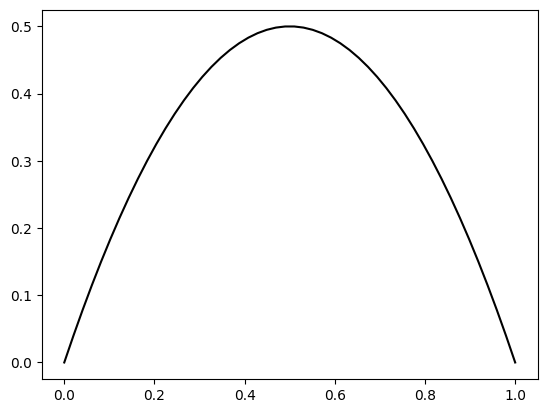

In [4]:
def plot_logistic(r):
    x = np.linspace(0, 1)
    fig, ax = plt.subplots(1, 1)
    ax.plot(x, logistic(r, x), 'k')
    
plot_logistic(2)

We are now interested in studying the accumulation points of the logistic map for difference values of $\mu$. We won't do a formal study of them. Instead, we will plot the logistic map sequence for a few values of $\mu$.

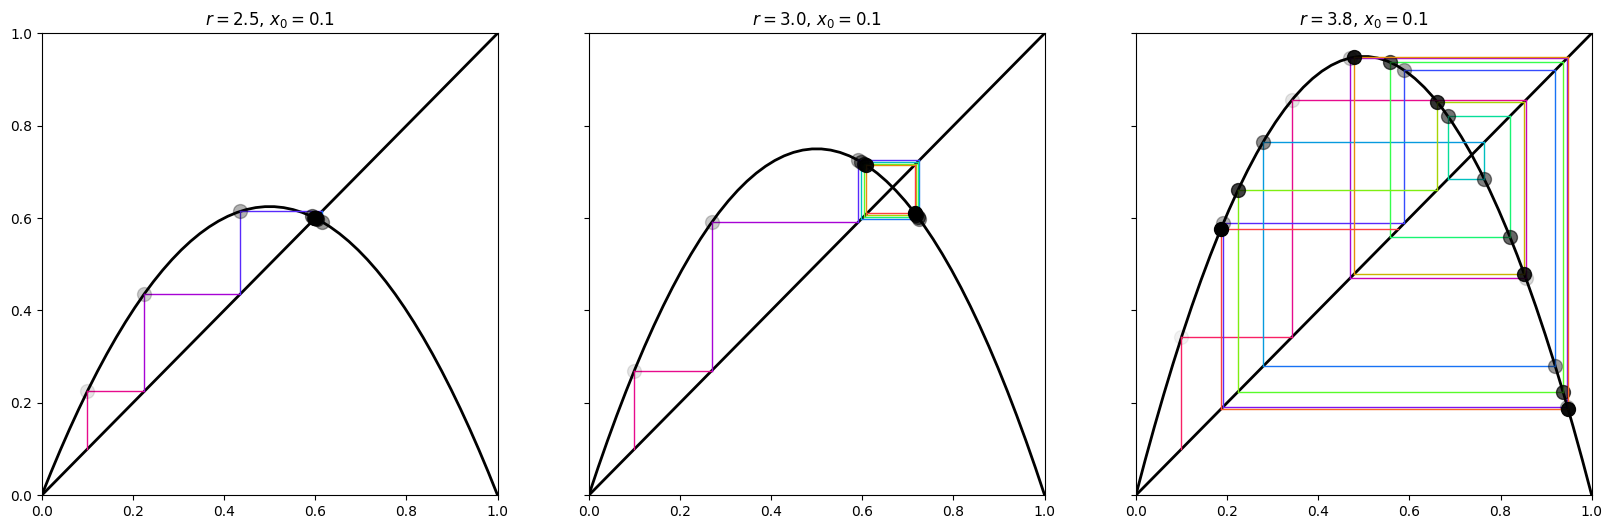

In [5]:
def plot_system(r, x0, n, ax):
    # Plot the function and the y=x diagonal line.
    t = np.linspace(0, 1)
    ax.plot(t, logistic(r, t), 'k', lw=2)
    ax.plot([0, 1], [0, 1], 'k', lw=2)

    # Recursively apply y=f(x) and plot two lines:
    # (x, x) -> (x, y) -> (y, y)
    x = x0
    for i in range(n):
        # Pick a color for the line
        angle = (i + 1) / n * 2 * math.pi
        color = (
            math.cos(angle),
            math.cos(angle + 2 * math.pi / 3),
            math.cos(angle - 2 * math.pi / 3))
        color = tuple(x / 2 + 1/2 for x in color)
        # Compute y = f(x) using the logistic map
        y = logistic(r, x)
        # Plot the two lines.
        ax.plot([x, x], [x, y], color=color, lw=1)
        ax.plot([x, y], [y, y], color=color, lw=1)
        # Plot the positions with increasing opacity.
        ax.plot([x], [y], 'ok', ms=10, alpha=(i + 1) / n)
        # Move to next point
        x = y

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(f"$r={r:.1f}, \, x_0={x0:.1f}$")

fig, (ax1, ax2, ax3) = \
  plt.subplots(1, 3, figsize=(20, 6), sharey=True)
plot_system(2.5, .1, 10, ax1)
plot_system(3.0, .1, 10, ax2)
plot_system(3.8, .1, 20, ax3)

We distinguish here 3 behaviours. On the left graph, the logistic map converges to the intersection point of the curve and the diagonal line. On the middle graph, the logistic map is oscillating between two values. Last, on the right graph, we observe what seems to be a chaotic behavior.

On the diagram below, we plot the accumulation points of the logistic map (the value of $\mu$ is on the $x$-axis whereas the accumulation points are on the $y$-axis). We can see that for high values of $\mu$, the logistic map exhibits a chaotic behaviour. Such a behaviour demonstrate that, even if deterministic, we might have solutions to generate pseudo-random number sequences. We will see one example in the next section.

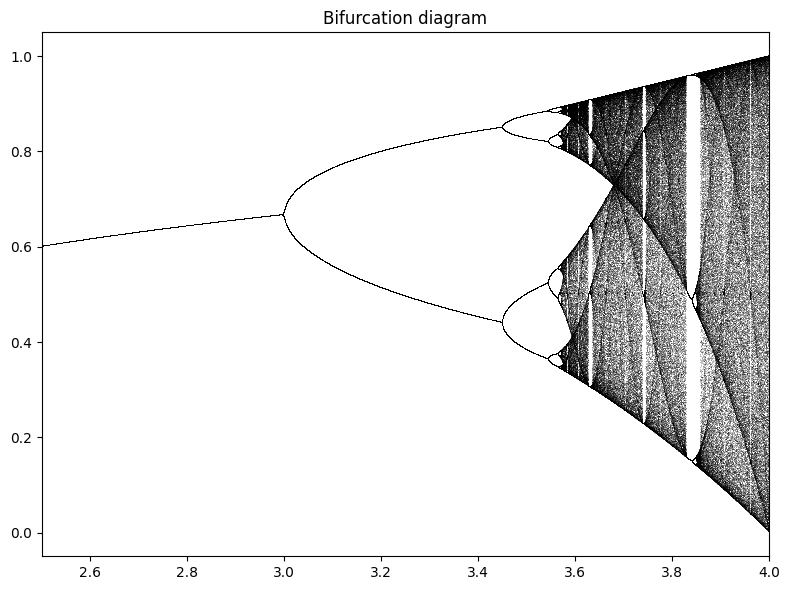

In [6]:
def birfucation_diagram():
    n, iterations, last = 10_000, 1_000, 100
    r = np.linspace(2.5, 4.0, n)
    x = 1e-5 * np.ones(n)

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    for i in range(iterations):
        x = logistic(r, x)
        if i >= (iterations - last):
            ax.plot(r, x, ',k', alpha=.25)
    ax.set_xlim(2.5, 4)
    ax.set_title("Bifurcation diagram")

    plt.tight_layout()
    
birfucation_diagram()

## LCG Generator

In this section, we will describe a class of PRNG called *Linear Congruential Generator* (LCG). LCG is one of the oldest PRNG and is very fast and space efficient.

LCG is defined by the following recurrence:

$$X_{n+1} = a X_{n} + c \mod m$$

where $m$ is the modulus ($m > 0$), $a$ is the multiplier ($0 < a < m$) and $c$ is the increment ($0 \leq c < m$).

The quality of the generator will depend entirely on the choice of $a$, $c$ and $m$ and this, for any possible value of the seed $X_0$. For instance, choosing the values $a$, $c$ and $m$ at random is not a good idea, as this leads, with an overwhelming propability, with a PRNG with a short period.

With give below a Python implementation of LCG (the values of $a$, $c$ and $m$ are taken from the GNU C library):

In [7]:
class LCG:
    def __init__(self, a=1103515245, b=12345, m=(1<<31), seed=None):
        self._a = a
        self._b = b
        self._m = m
        self._x = seed
        
        if self._x is None:
            # If an explicit seed is not given...
            # ...generates one using Python PRNG
            self._x = random.randrange(0, m)

    def random(self):
        self._x = (self._x * self._a + self._b) % self._m
        return self._x / self._m
    
lcg = LCG()
[lcg.random() for i in range(8)]

[0.58519456256181,
 0.07806935673579574,
 0.32529978081583977,
 0.32544346945360303,
 0.9277485115453601,
 0.016369115095585585,
 0.05514407344162464,
 0.7142381579615176]

We can try to generate some graphics to see if the PRNG is not totally broken, by plotting points the are uniformly generated at random in the 3D space:

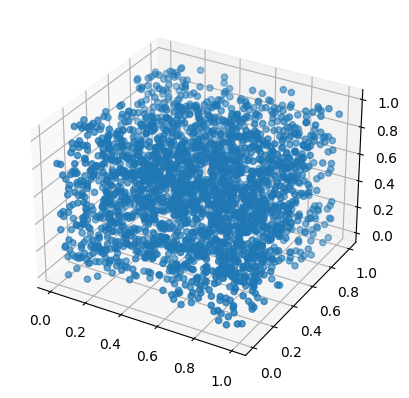

In [8]:
def lcg_stats(lcg, n = 500):
    fig = plt.figure()
    ax  = fig.add_subplot(111, projection='3d')
    xs  = [lcg.random() for _ in range(n)]
    ys  = [lcg.random() for _ in range(n)]
    zs  = [lcg.random() for _ in range(n)]
    ax.scatter(xs, ys, zs)
    return plt

_ = lcg_stats(LCG(), 2500)

What we observe is that the points seem to be evenly spread.

For example, compare the above graphic with the following one (where the LCG parameters are known to be bad ones), where we see that for different parameters, the LCG generator exhibits a bad bahaviour, where there are clusters of points:

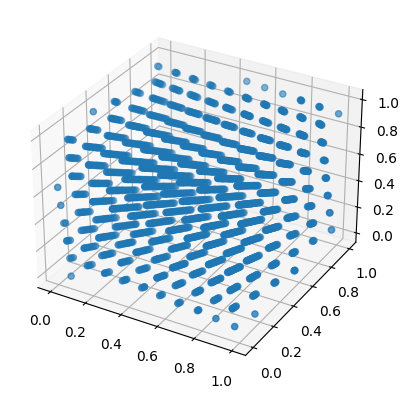

In [9]:
_ = lcg_stats(LCG(1229, 1, 2048), 2500)

There exists cryptographically secure PRNG. For example, under the hardness assumption of fatorizing numbers in prime factors, the sequence generated by a *Blum Blum Shub* from a truly random seed is indistinguishable from a random sequence. The seed are then generated from various sources, like material floating in lava lamps!

# Simulating non-uniform distributions

All the PRNG we have seen so far generates uniformly distributed random numbers. But what if we want random numbers from a given distribution? For example, how could we simulate a biased coin with probability $p$ for Head (denoted by `True`). In fact, this can be easy implemented with `random.random()`, as shown below:

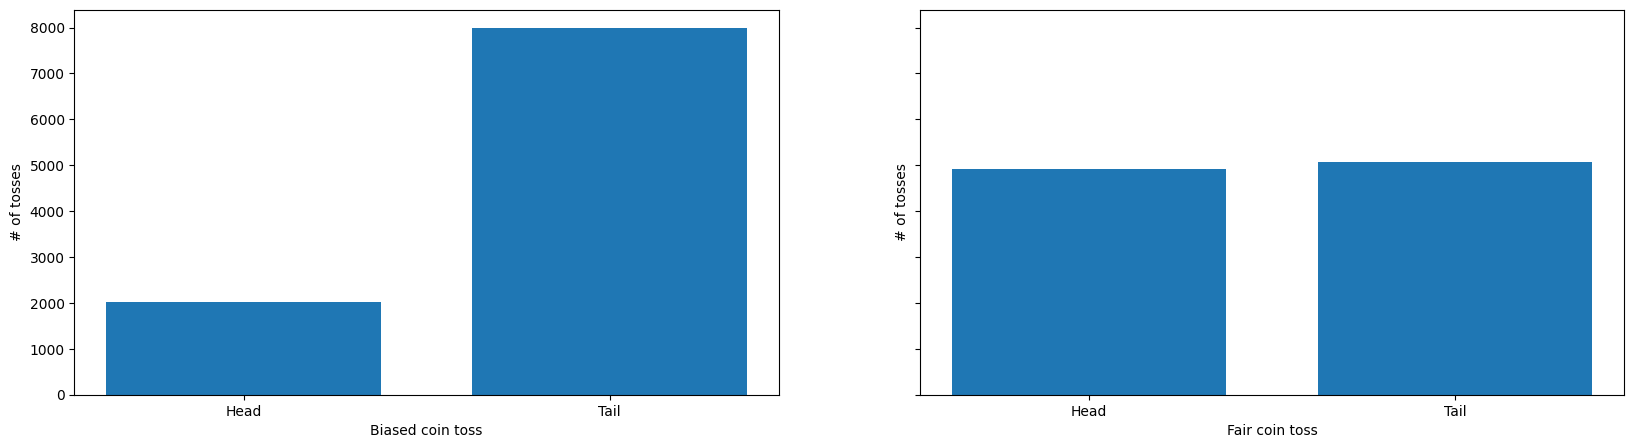

In [10]:
def biased_coin(p):
    # Biased coin toss - "p \in [0,1]" is our coin bias
    return (0 if random.random() < p else 1)

def biased_coin_stats():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
    
    # For the experiment, we use a bias of 0.2 for heads
    N, P = 10_000, 0.2
    
    # First histogram for biased flips
    ax1.set_ylabel('# of tosses')    
    ax1.set_xlabel('Biased coin toss')
    ax1.hist([biased_coin(P) for _ in range(N)], 2, rwidth=0.75)

    # Second histogram for uniform flips
    ax2.set_ylabel('# of tosses')    
    ax2.set_xlabel('Fair coin toss')
    ax2.hist([random.randint(0, 1) for _ in range(N)], 2, rwidth=0.75)
    
    for ax in [ax1, ax2]:
        ax.set_xticks([0.25, 0.75])
        ax.set_xticklabels(['Head', 'Tail'])

    return fig

_ = biased_coin_stats()

We see that on the left diagram, we have a ratio *heads / tosses* of roughly $0.2$, that corresponds to the bias in our experiment. The function implementation reliss on the definition of uniform distributions over dense intervals: the probability of picking a number in $[0,p)$ is exactly $\frac{|[0,p)|}{|[0,1)|}$, i.e. $p$. This way of doing can be generalized to the problem of picking a value in the set $\{E_1, E_2, \ldots, E_n\}$ with resp. probability $p_1, p_2, \ldots, p_n$ ($0 \leq p_i \leq 1$ and $\sum_i p_i = 1$).

# Rejection sampling

## Fair coin toss

We can also go in the other direction. Assume that we have a coin with bias $p \in (0, 1)$ for Head. We want to simulate an unbiased coin from the biased one. This can be done via a methdology called *rejection sampling*. In the example of the biased coin, this can be done as follows:

 1. toss the biased coin twice (*sample*),
 2. if the results are the same, go back to 1 (*reject*),
 3. otherwise, return the first result.

Here is an implementation in Python:

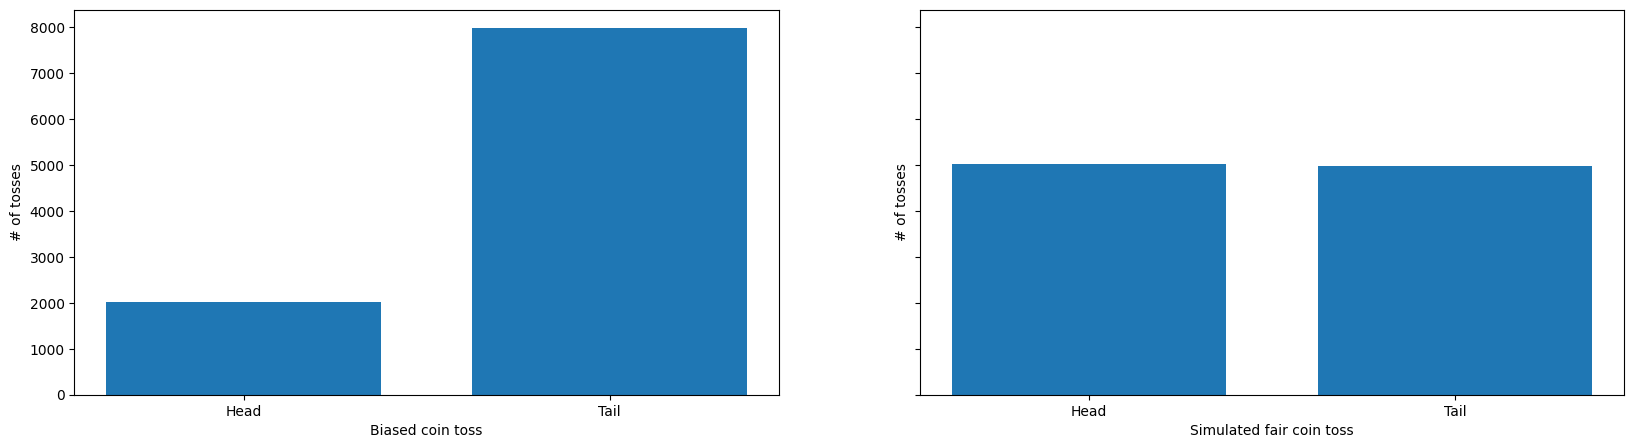

In [11]:
def unbiased_coin(p):
    # Note that we also return the number of double coin flips.

    counter = 0
    while True:
        counter += 1
        b0 = biased_coin(p)
        b1 = biased_coin(p)
        if b0 != b1:
            return (counter, b0)
        
def unbiased_coins_stats():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), sharey=True)

    # For the experiment, we use a bias of 0.2 for heads
    N, P = 10_000, 0.2

    # First histogram for biased flips
    ax1.set_ylabel('# of tosses')    
    ax1.set_xlabel('Biased coin toss')
    ax1.hist([biased_coin(P) for _ in range(N)], 2, rwidth=0.75)

    # Second histogram for uniform flips
    ax2.set_ylabel('# of tosses')    
    ax2.set_xlabel('Simulated fair coin toss')
    ax2.hist([unbiased_coin(P)[1] for _ in range(N)], 2, rwidth=0.75)    
    
    for ax in [ax1, ax2]:
        ax.set_xticks([0.25, 0.75])
        ax.set_xticklabels(['Head', 'Tail'])
    
    return plt

_ = unbiased_coins_stats()

We see that the simulated fair coin is indeed fair (over $10000$ tosses, roughly $5000$ resulted in Head and $5000$ resulted in Tail). The idea is the following: the probability of sampling `Head` then `Tail` is $p(1-p)$ while the one of sampling `Tail` then `Head` is $(1-p)p$, meaning that these two events have the same probability. Basically, after one iteration of the loop, the propabilities of returning `Head` or or returning `Tail` are equal. Now, there are two more events: we could toss `Head` then `Head` or `Tail` then `Tail`. We are not interested in these, so we simply reject them and restart the process that will eventually stop. We can estimate the number of needed double coin flips:

Average double flips: 3.1242


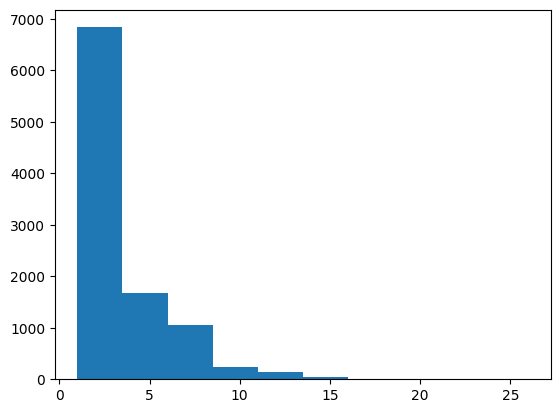

In [12]:
def unbiased_coins_stats_flips():
    N, P = 10_000, 0.2
    Fs = [unbiased_coin(P)[0] for _ in range(N)]
    print('Average double flips:', sum(Fs)/N)
    plt.hist(Fs); return plt

_ = unbiased_coins_stats_flips()

## Sampling in a range from a source of random bits

Suppose that we have a random number generator that uniformly samples integer in $[0, 2^n)$ - i.e. that uniformly samples bit-strings of size $n$. How could with transofmr such a generator into one that would uniformly generate integers in some othre range, say $[p, q)$? One way to do so it to generator $x \in [0, 2^n)$ and then to return `p + x * (q - p) // n` --  i.e. by scaling and shifting the range $[0, 2^n)$ to $[p, q)$. However, since integer division rounds down, even if the source of randomness is perfect, the obtained distribution will be biased. When $2^n >> (q - p)$ and when there is no need for a strong PRGN, this kind of scaling makes sense. But what to do when the introduction of such a biased is not acceptable.

Here too, rejection sampling can come to the rescue, as shown in the following algorithm:

  1. sample an integer $u$ in $[0, 2^n)$ (*sample*),
  2. if $u \geq (q-p)$, go back to 1 (*reject*),
  3. return $p + u$.

# Las Vegas Algorithms

A *Las Vegas algorithm* is a probabilistic algorithm that always gives a correct result. Randomness is here used to enhance its average time complexity. An emblematic example of Las Vegas algorithms is the *Randomized Quick Sort*.

## Quicksort

Before moving to randomized quick sort, I'll first introduce its non randomized version. Quicksort is a sorting algorithm invented by Hoare in 19611. It is based on the divide and conquer methodology and achieves an average complexity of $\mathcal{O}(n\ \log(n))$ comparisons for an array of size $n$ (which is optimal for a comparative sort) and a quadratic ($\mathcal{O}(n^2)$) worst case complexity. Despite this theoretical disadvantage, it is in practice one of the fastest sorters. Moreover, as we will see below, the worst case is unlikely when the algorithm is correctly implemented.

The algorithm consists of placing an element of the array in its final position by swapping all the elements so that all those below the pivot are to its left and all those above the pivot are to its right -- this phase of the algorithm is called *partitioning*. Then, for each sub-array, the process is repeated recursively, until all items are sorted. A good sketch being better than a long speech, you can get an intuition on how Quicksort works by looking at the following Hungarian dance: [Quick-sort with Hungarian (Küküllőmenti legényes) folk dance](https://www.youtube.com/watch?v=ywWBy6J5gz8) (yes, this video achieves a high level of nerdiness).

A Python implementation of Quicksort is given below. It is not very important that fully understand the details. We will mainly focus on the choice of the pivot in `_partition`. In the implementation below, the pivot is always arbitrarily chosen as the first element of the sub-array we are partitioning.

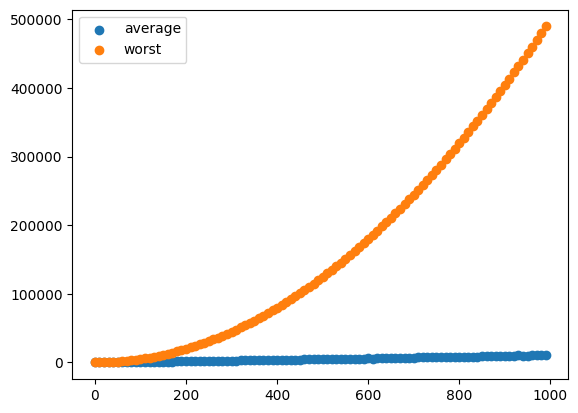

In [13]:
def _partition(xs, i, j, stats = None):
    # Partition the sub-array xs[i:j]. We use `stats` (a list
    # containing only one element) as a way to count the number
    # of comparisons made.
    b, pivot = i+1, xs[i]
    
    # We arrange the array s.t. all the elements so that all
    # those below the pivot are to its left and all those above
    # the pivot are to its right.
    for k in range(i+1, j):
        if stats:
            stats[0] += 1
        if xs[k] < pivot:           
            xs[b], xs[k], b = xs[k], xs[b], b+1
    xs[b-1], xs[i] = xs[i], xs[b-1]
    
    # We return the pivot new index
    return b-1

def _quick_sort(xs, i, j, stats = None):
    if i < j:
        # We partition the table
        mid = _partition(xs, i, j, stats)
        # We rec. sort the sub-array on the left of the pivot...
        _quick_sort(xs, i, mid, stats)
        # ...and on its right
        _quick_sort(xs, mid+1, j, stats)

def quick_sort(xs):
    stats = [0]; _quick_sort(xs, 0, len(xs), stats)
    return (stats[0], xs)

def quick_sort_stats():
    # In this function, we are going to sort different arrays of
    # different sizes. (Note that the arrays are randomly generated...)
    #
    # However, at each iteration, we are going to sort the array twice.
    # This means that second call to `quick_sort` is triggered on an
    # array that is already sorted.
    #
    # For each scenario, we count the total number of comparisons. Then,
    # we plot some graphic that displays the number of comparisons made
    # by the sorting algorithm w.r.t. the length of its input argument.
    nrounds, stats = 5, {}
    for i in range(0, 1000, 10):
        stats1, stats2 = 0, 0
        for j in range(nrounds):
            xs = list(range(i))
            random.shuffle(xs)
            stats1 += quick_sort(xs)[0]
            stats2 += quick_sort(xs)[0]
        stats[i] = tuple(x / nrounds for x in [stats1, stats2])
    stats = [(k, v[0], v[1]) for k, v in stats.items()]
    plt.scatter([x[0] for x in stats], [x[1] for x in stats], label = 'average')
    plt.scatter([x[0] for x in stats], [x[2] for x in stats], label = 'worst')
    plt.legend(loc = 'upper left')
    return plt

_ = quick_sort_stats()

If you look at the graphic above, you see that in average (i.e. when sorting arrays that are randomly generated), the number of comparisons is roughly proportional to $\mathcal{O}(n\ \log(n))$. However, the same graphic shows that the complexity of Quicksort degrades on arrays that are already sorted - it is then quadratic! This comes from the choice of the pivot element: by choosing the first element, partioning an already sorted array of size `n` leads to two sub-arrays of respective size `0` and `n-1` -- such a behaviour totally kills the divide and conquer strategy.

One way to overcome this difficulty is to have a better strategy for choosing the pivot. Randomized quicksort is such strategy.

## Randomized quicksort

Randomized quick only differs from quicksort in its way to choose the pivot. In randomized quicksort, the pivot is chosen randomly & uniformly in the sub-array to sort -- the rest of the algorithm being identical to its deterministic counterpart.

We give below a Python implementation of randomized quicksort.

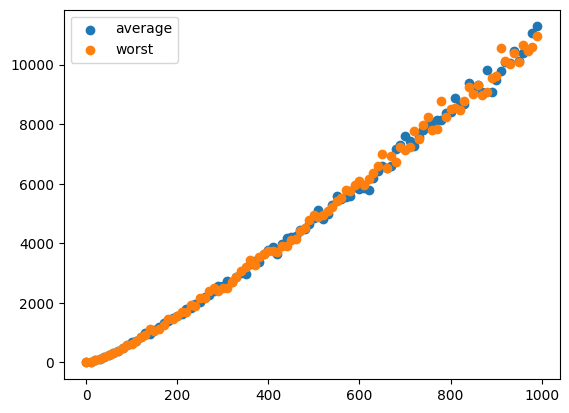

In [14]:
def _rnd_partition(xs, i, j, stats = None):
    # In randomized partitioning, we choose the pivot at random
    pivot = random.randrange(i, j)

    # The rest of the algorithm stays unchanged
    xs[i], xs[pivot] = xs[pivot], xs[i]
    
    b, pivot = i+1, xs[i]
    for k in range(i+1, j):
        if stats:
            stats[0] += 1
        if xs[k] < pivot:           
            xs[b], xs[k], b = xs[k], xs[b], b+1
    xs[b-1], xs[i] = xs[i], xs[b-1]
    return b-1

def _rnd_quick_sort(xs, i, j, stats = None):
    # Randomized quicksort only differs from quicksort by its
    # usage of randomized partitioning
    if i < j:
        mid = _rnd_partition(xs, i, j, stats)
        _rnd_quick_sort(xs, i, mid, stats)
        _rnd_quick_sort(xs, mid+1, j, stats)

def rnd_quick_sort(xs):
    stats = [0]; _rnd_quick_sort(xs, 0, len(xs), stats)
    return (stats[0], xs)

def rnd_quick_sort_stats():
    # It's time to do some stats. The way we draw the data for
    # `rnd_quick_sort` is the same as we did for deterministic
    # quicksort.
    nrounds, stats = 5, {}
    for i in range(0, 1000, 10):
        stats1, stats2 = 0, 0
        for j in range(nrounds):
            xs = list(range(i))
            random.shuffle(xs)
            stats1 += rnd_quick_sort(xs)[0]
            stats2 += rnd_quick_sort(xs)[0]
        stats[i] = tuple(x / nrounds for x in [stats1, stats2])
    stats = [(k, v[0], v[1]) for k, v in stats.items()]
    plt.scatter([x[0] for x in stats], [x[1] for x in stats], label = 'average')
    plt.scatter([x[0] for x in stats], [x[2] for x in stats], label = 'worst')
    plt.legend(loc = 'upper left')
    return plt

_ = rnd_quick_sort_stats()

We can now see that randomized quicksort follows a $\mathcal{O}(n\ \log(n))$ complexivity regardless on wether the input array is sorted or not. It can be shown that, for any input, the average complexity of randomized quicksort is in $\mathcal{O}(n\ \log(n))$ -- this is different from quicksort where the average complexivity (taken on all the inputs) is also in $\mathcal{O}(n\ \log(n))$, but where there exist lists (e.g. sorted lits) for which the sorting complexity is *always* quadratic. (**Note**: ramdomized quick sort still have a quadratic complexity in worst case -- if you are unlucky, the randomly chosen pivots may be s.t. the partitioning is always unbalanced. However, one can prove that the standard deviation of the complexity is linear, meaning that the algorithm deviates little from the average execution time)

In conclusion, randomized quicksort is a Las Vegas algorithm:
  - it always give the correct answer, but
  - use randomness as a way to improve at complexity.

## Monte-Carlo Algorithms

A Monte Carlo algorithm is a randomized algorithm whose execution time is deterministic, but whose result can be incorrect with a certain (usually minimal) probability. In other words, a Monte-Carlo algorithm is an algorithm that uses a source of randomness to increase its efficiency, but that might fail with a low probability. Monte Carlo algorithm are also used for statistical estimations & simulations (this is what we did just above for estimating the average complexity of quicksort!)

### Primality test

One of the most known Monte Carlo algorithm is the *Miller-Rabin primality test*. The algorithm decides wether a integer is prime or not, with a small probability of error. It main components is a randomized procedure that is repeated a fixed number of time (here, `32` by default). All iterations are independent (because we sample a new `a`) and decide wether the input number `n` is composite or probably prime. Since all iterations are independent, the more we repeat the internal loop, the less the probability of error is. For instance, for $k=25$, the error probability is around $2^{-50}$. Note that when the algorithm returns that a number is composite, then the answer is definitive and correct - we say that the algorithm has one-sided errors.

In [15]:
def is_prime(n, k = 32):
    if n <= 0: raise ValueError(n)
    if n <= 3: return n != 1

    r, d = 0, n - 1
    while d % 2 == 0:
        r  += 1
        d //= 2

    for _ in range(k):
        # This is our internal procedure. It detects with a
        # given probablity if a number is prime or not.
        # This procedure is probabilistic and only detect that
        # a number is composite with a fixed probability.
        # This is why we repeat it multiple times. The more we
        # repeat it, the less is the chance that we do not detect
        # that "n" is composite
        a = random.randint(2, n - 2)
        x = pow(a, d, n)

        if x == 1 or x == n - 1:
            continue

        for _ in range(r-1):
            x = pow(x, 2, n)
            if x == n - 1:
                break
            if x == 1:
                return False
        else:
            return False

    # We did not detect that "n" is composite. Hence, there is
    # a very high probability that "n" is prime.
    return True

### Monte-Carlo Simulation

Monte-Carlo simulation in an algorithmic method for calculating an approximate numerical value using randomized algorithm. We give here several examples.

#### Estimation of $\pi$.

For that purpose, we take the unit circle centered on $(0, 0$). Its area is $\pi\ r^2$ with $r = 1$, i.e., $\pi$. We now use Monte-Carlo simulation to approximate it.

1. We first find an enclosing set with nice properties

   * E.g. the square from $(-1, -1)$ to $(1, 1)$
   * Its area is $2^2 = 4$.
   * A uniformly chosen random point in the square is $(x, y)$ where $x$ and $y$ are uniformly chosen in $[-1, 1)$.


2. We then choose a large number (say 10,000) of samples


3. We find the fraction of samples that land in target

   * For any $(x, y)$ we pick, it must be that $x^2 + y^2 \le 1$.
   * Say this fraction is $k$.


4. Hence, $\pi/4 = k$, so $\pi = 4\ k$.

In [16]:
def monte_carlo_pi(n=10_000):
    counter = 0
    for _ in range(n):
        x = -1.0 + random.random() * 2.0
        y = -1.0 + random.random() * 2.0
        counter += bool(x**2 + y**2 <= 1)
    return 4 * (counter / n)

# Try it out for some sample sizes
for n in [10**n for n in range(7)]:
    est_pi = monte_carlo_pi(n)
    print('Estimate with {} samples: {:.5f}'.format(n, est_pi))

Estimate with 1 samples: 0.00000
Estimate with 10 samples: 3.60000
Estimate with 100 samples: 3.12000
Estimate with 1000 samples: 3.12800
Estimate with 10000 samples: 3.14080
Estimate with 100000 samples: 3.14808
Estimate with 1000000 samples: 3.14343


#### Populations

Assume that we want to study the population of a set of particles that have a decaying probability, after one second, of $p$. For instance, given $m$ such particles, what is the number of molecules remaining after $t$ seconds?

This problem can be solved analytically: after $t$ seconds, the population is of $m \cdot (1-p)^t$. However, let's use Monte Carlo simulation to estimate that population:

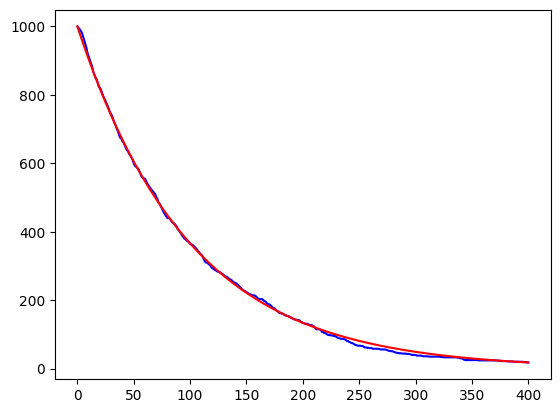

In [17]:
def simulate_particles(p, m, t):
    # Initially, we have `m` particles
    count = [m] # initially there are m particles
    for _ in range(t):
        # Population at the previous clock tick
        last_pop = count[-1]
        # Current population
        next_pop = 0
        # for each such particle, see if it decays or not
        for _ in range(last_pop):
            if random.random() > p:
                # the particle did not decay
                next_pop += 1
        count.append(next_pop)
    return count

def analytic_particles(p, m, t):
    return [m * (1 - p) ** k for k in range(t+1)]

def simulate_particles_stats():
    P, M, M2, T = 0.01, 1_000, 10_000, 400
    plt.plot(range(T+1), simulate_particles(P, M, T), color='blue')
    plt.plot(range(T+1), analytic_particles(P, M, T), color='red')
    #plt.plot(range(T+1), simulate_particles(P, M2, T), color='blue')
    #plt.plot(range(T+1), analytic_particles(P, M2, T), color='red')
    return plt

_ = simulate_particles_stats()